# ABEL scanning example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

initializing ocelot...


### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]

# define stage
stage = StageQuasistatic2d()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5

# define first stage (half length)
first_stage = StageQuasistatic2d()
first_stage.driver_source = stage.driver_source
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 18e-6 # [m]
source.z_offset = -34e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 5000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1.0 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulation scan

In [3]:
# scan the driver timing jitter
#linac.scan('scan_example', 
#           lambda obj, val: setattr(obj.stage.driver_source.jitter, 't', val) or obj, 
#           np.logspace(-15.5, -13.5, 16),
#           label='Driver timing jitter (fs rms)',
#           scale=1e-5,
#           num_shots_per_step=1, 
#           parallel=True,
#           overwrite=False);
linac.scan('scan_example_emittance', 
           lambda obj, val: setattr(obj.source, 'emit_nx', val) or obj, 
           1e-6*np.array([10, 20, 40, 80, 160]),
           label='Horizontal normalized emittance (mm mrad)',
           scale=1e-6,
           num_shots_per_step=1, 
           parallel=True,
           overwrite=False);

Output()

initializing ocelot...
>> SHOT 3/5
initializing ocelot...
>> SHOT 1/5
initializing ocelot...
>> SHOT 4/5
initializing ocelot...
>> SHOT 2/5
initializing ocelot...
>> SHOT 5/5


/pfs/lustrep2/scratch/project_465000445/kalvik/master_kalvik/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))
/pfs/lustrep2/scratch/project_465000445/kalvik/master_kalvik/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))
/pfs/lustrep2/scratch/project_465000445/kalvik/master_kalvik/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))
/pfs/lustrep2/scratch/project_465000445/kalvik/master_kalvik/lib/python3.9/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np

### Plot wakefield

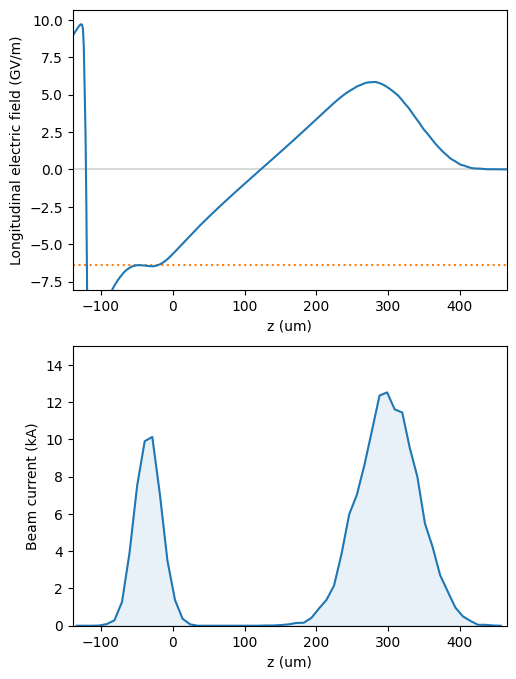

In [4]:
linac.stages[0].plot_wakefield()

### Plot scan

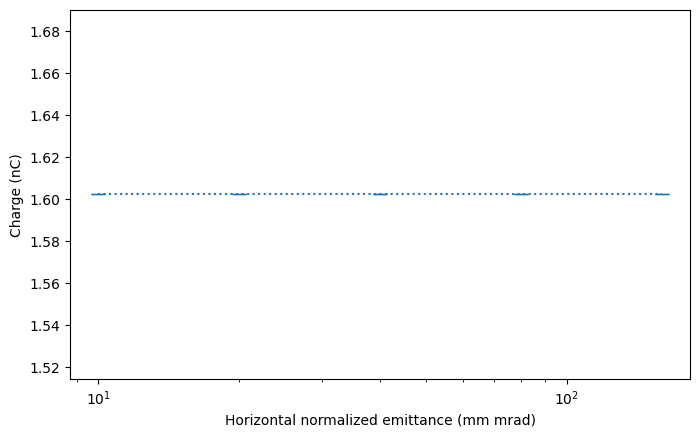

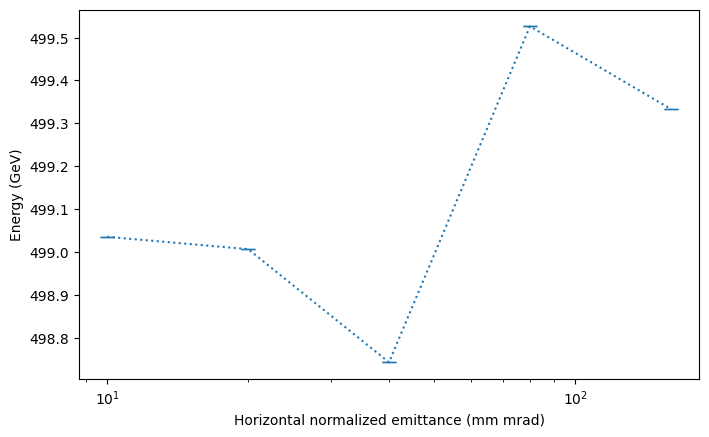

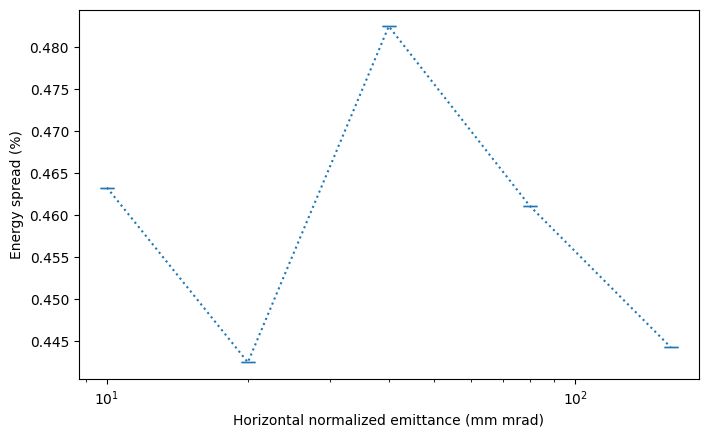

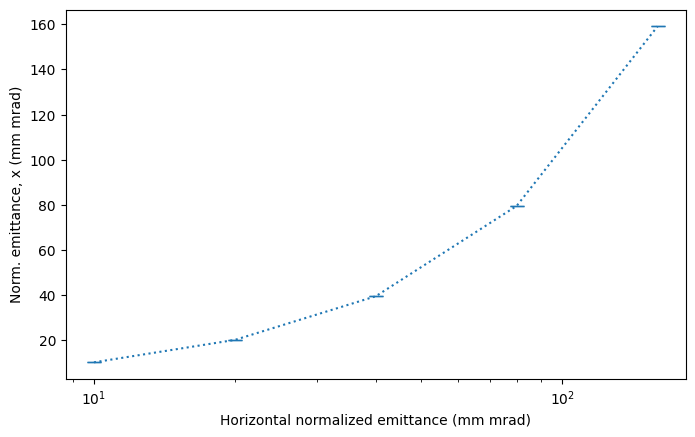

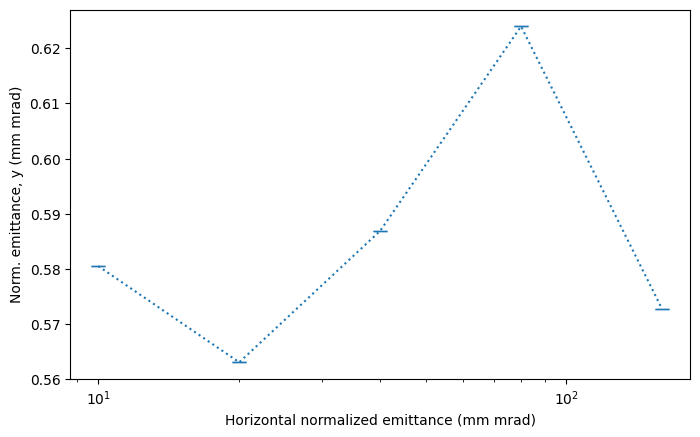

In [5]:
# plot energy spread vs bunch length
# plot energy spread vs bunch length
fig_1 = linac.plot_beam_function(Beam.charge, label='Charge (nC)', scale=-1e-9, xscale='log', yscale='linear')
fig_2 = linac.plot_beam_function(Beam.energy, label='Energy (GeV)', scale=1e9, xscale='log', yscale='linear')
fig_3 = linac.plot_beam_function(Beam.rel_energy_spread, label='Energy spread (%)', scale=1e-2, xscale='log')
fig_4 = linac.plot_beam_function(Beam.norm_emittance_x, label='Norm. emittance, x (mm mrad)', scale=1e-6, xscale='log')
fig_5 = linac.plot_beam_function(Beam.norm_emittance_y, label='Norm. emittance, y (mm mrad)', scale=1e-6, xscale='log')

In [6]:
plots = np.array(['charge', 'energy', 'energy_spread', \
                       'emittance_x', 'emittance_y'])
figs = [fig_1, fig_2, fig_3, fig_4, fig_5]
for pl, f in zip(plots,figs):
    f.savefig(fname = f'Linac_emittance_scan_{pl}_RR_disabled.png')

In [7]:
for i in range(5):
    linac[i].animate_lps(file_name=f'emittance_{10*2**i}_RR_disabled')